In [5]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import logging
import pandas as pd
import xarray as xr
from stompy.grid import multi_ugrid
from stompy import utils
import os
import six
import matplotlib.pyplot as plt
%matplotlib notebook

In [6]:
fig_dir="fig-scenarios-20220810"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [7]:
import run_database
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
def load_or_none(rd):
    try:
        return dfm.DFlowModel.load(rd)
    except FileNotFoundError:
        return None

Stage
---

In [8]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
if 1:
    runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016long')].copy()
    runs['name']=runs.scen.map({0:'Base',1:'Low',2:'Medium',3:'High'})
runs

run_dir  scen  layers    period  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v027     0     100  2016long   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  2016long   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  2016long   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  2016long   

    status     flows comments  slr    name  
0  running  impaired      NaN  NaN    Base  
1  running  impaired      NaN  NaN     Low  
2  stopped  impaired      NaN  NaN  Medium  
3  running  impaired      NaN  NaN    High

In [9]:
six.moves.reload_module(dfm)
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

In [10]:
# This step is painfully slow, even when run on a high2 node.
# maybe 4 minutes?
# each his file is O(30GB)
def load_his(mod):
    print(f"Loading history from {mod.run_dir}")
    return mod.his_dataset(chain=True)
runs['his']=runs.model.apply(load_his)

Loading history from data_2016long_3d_asbuilt_impaired_scen0_l100-v027
1 chained datasets
Loading history from data_2016long_3d_asbuilt_impaired_scen1_l100-v004_r00
2 chained datasets
Loading history from data_2016long_3d_asbuilt_impaired_scen2_l100-v007_r00
2 chained datasets
Loading history from data_2016long_3d_asbuilt_impaired_scen3_l100-v010_r00
2 chained datasets


ValueError: arguments without labels along dimension 'cross_section_geom_nNodes' cannot be aligned because they have different dimension sizes: {172, 262}

In [15]:
# Work through issue with number of sections changing.
mod=runs.model.values[3]
self=mod
import glob

#mod.his_dataset(chain=True)

clean_kwargs=dict(decode_geometry=True,                                                                                            
                  set_coordinates=True)                                                                                                        

#if chain:                                                                                                                                     
mdus=self.chain_restarts()                                                                                                                
his_fns=[]                                                                                                                                
for mdu in mdus:                                                                                                                          
    output_dir=mdu.output_dir()                                                                                                           
    fns=glob.glob(os.path.join(output_dir,'*_his.nc'))                                                                                    
    fns.sort()                                                                                                                            
    his_fns.append(fns[0])                                                                                                                
his_dss=[self.clean_his_dataset(fn,**clean_kwargs)                                                                                        
         for fn in his_fns]                                                                                                               
his_dasks=[]                                                                                                                              
for ds in his_dss[::-1]:                                                                                                                  
    if len(his_dasks)>0:                                                                                                                  
        cutoff=his_dasks[0].time.values[0]                                                                                                
        tidx=np.searchsorted( ds.time.values, cutoff)                                                                                     
        if tidx==0:                                                                                                                       
            continue                                                                                                                      
        ds=ds.isel(time=slice(0,tidx))                                                                                                    
    dask_ds=ds.chunk()                                                                                                                    
    his_dasks.insert(0,dask_ds)

# This fails.
#his_ds=xr.concat(his_dasks,dim='time')

ValueError: arguments without labels along dimension 'cross_section_geom_nNodes' cannot be aligned because they have different dimension sizes: {172, 262}

In [22]:
print(his_dss[0].dims)
print(his_dss[1].dims)
# cross_section and cross_section_geom_nNodes differ.

Frozen(SortedKeysDict({'nFlowElemWithBnd': 5137, 'nFlowElemContourPts': 4, 'nNetLink': 8718, 'nNetLinkPts': 2, 'nFlowLink': 8469, 'nFlowLinkPts': 2, 'stations': 177, 'station_geom_nNodes': 177, 'time': 20081, 'laydim': 100, 'laydimw': 101, 'cross_section': 16, 'cross_section_geom_nNodes': 172, 'source_sink': 2, 'source_sink_geom_nNodes': 4, 'source_sink_pts': 3, 'general_structures': 3, 'weirgens': 2}))
Frozen(SortedKeysDict({'nFlowElemWithBnd': 5137, 'nFlowElemContourPts': 4, 'nNetLink': 8718, 'nNetLinkPts': 2, 'nFlowLink': 8469, 'nFlowLinkPts': 2, 'stations': 177, 'station_geom_nNodes': 177, 'time': 253, 'laydim': 100, 'laydimw': 101, 'cross_section': 18, 'cross_section_geom_nNodes': 262, 'source_sink': 2, 'source_sink_geom_nNodes': 4, 'source_sink_pts': 3, 'general_structures': 3, 'weirgens': 2}))


In [26]:
his_dss[1]

<xarray.Dataset>
Dimensions:                                       (cross_section: 18, cross_section_geom_nNodes: 262, general_structures: 3, laydim: 100, laydimw: 101, nFlowElemContourPts: 4, nFlowElemWithBnd: 5137, nFlowLink: 8469, nFlowLinkPts: 2, nNetLink: 8718, nNetLinkPts: 2, source_sink: 2, source_sink_geom_nNodes: 4, source_sink_pts: 3, station_geom_nNodes: 177, stations: 177, time: 253, weirgens: 2)
Coordinates:
    station_x_coordinate                          (stations) float64 ...
    station_y_coordinate                          (stations) float64 ...
    station_name                                  (stations) |S256 b'pch_up                                                                                                                                                                                                                                                          ' ... b'seepageB                                                                                        

In [29]:
# For the common case of new cross sections being added, can slice
# to make datasets compatible.
ds0=his_dss[0]
dss_aligned=[his_dss[0]]

# dimensions and data for choosing how to truncate.
# check the values in the given variable (could be the coordinate) to see
# if truncation is valid.
truncate=[('cross_section','cross_section'),
          ('cross_section_geom_nNodes','cross_section_geom_node_coordx')]

for ds in his_dss[1:]:
    for dim,dvar in truncate:
        if dim not in ds.dims: continue # older output handles cross_section node differently
        assert ds.dims[dim] >= ds0.dims[dim],"Only truncation has been implemented"
        
        # As needed, slice cross_section and cross_section_geom_nNodes (if exists)
        if ds.dims[dim]>ds0.dims[dim]:
            dim_slice=slice(0,ds0.dims[dim])
            slc={dim:dim_slice}
            # would it be better to use .values?
            if not np.all(ds[dvar].isel(slc).values == ds0[dvar].values):
                print(dim,dvar)
                print(ds[dvar].isel(slc).values)
                print(ds0[dvar].values)
                print(ds[dvar].isel(slc).values - ds[])
                raise Exception("failed")
            ds=ds.isel(slc)
        else:
            assert np.all(ds[dvar]==ds0[dvar])
    dss_aligned.append(ds)
    

cross_section_geom_nNodes cross_section_geom_node_coordx
[552162.25716502 552152.62729169 552146.61142259 552142.1189306
 552138.12813636 552134.86620833 552131.89004481 552128.9094335
 552125.20111011 552121.36158909 552117.79276341 552114.73194824
 552328.31558268 552329.44621424 552331.14930611 552333.06243056
 552335.72999845 552338.1910707  552340.58506119 552342.92759244
 552345.24443961 552347.58144685 552349.92850497 552352.2331062
 552355.1522879  552358.52194795 552352.2331062  552350.46547652
 552348.42335524 552346.23577932 552344.04890839 552342.01834529
 552339.58048682 552580.84875    552583.77564362 552586.89042295
 552590.25388429 552593.81438775 552597.88889571 552602.96671014
 552575.40333365 552575.62600769 552575.87133114 552576.15857261
 552576.47176867 552576.81620666 552576.99016369 552577.389282
 552574.56582944 552574.54070665 552574.80925602 552575.103833
 552491.16737493 552492.65586345 552493.28573335 552493.8913451
 552494.42879987 552494.86722715 552495.3

Exception: failed

Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [ ]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['nmp','North Marsh Panne'],
                 ['npc','Ped. Bridge']]

def fig_waterlevel_timeseries(rec):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    # HERE need chaining
    his=rec['model'].his_dataset()
    
    for station,name in stage_stations:
        ax.plot(his.time,
                his.waterlevel.sel(stations=station),
                label=name)

    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    fig.subplots_adjust(right=0.72,left=0.1,top=0.98)
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    return fig

# Similar plots, but each panel is one station.
def fig_waterlevel_bystation_timeseries(runs,station,label):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    for _,rec in runs.iterrows():
        # HERE need chaining
        his=rec['model'].his_dataset()
    
        ax.plot(his.time,
                his.waterlevel.sel(stations=station),
                label=rec['name'],
                lw=1.5,alpha=0.6)

    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    return fig

def fig_waterlevel_discharge_bystation_timeseries(runs,station,label):
    fig,axs=plt.subplots(2,1,figsize=(7.5,4),sharex=True)

    # Stage at stations:
    colors={}
    ax=axs[0]
    for _,rec in runs.iterrows():
        # HERE need chaining
        his=rec['model'].his_dataset()
    
        l=ax.plot(his.time,
                  his.waterlevel.sel(stations=station),
                  label=rec['name'],
                  lw=1.5,alpha=0.6)
        colors[rec['name']]=l[0].get_color()

    if 1: # show mouth thalweg, too
        for _,rec in runs.iterrows():
            # HERE need chaining
            his=rec['model'].his_dataset()
            ax.plot(his.time,
                    his.general_structure_crest_level.sel(general_structures='mouth'),
                    label='__nolabel__',
                    ls='--',color=colors[rec['name']],
                    lw=1.5,alpha=0.6)
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')

    ax=axs[1]
    for _,rec in runs.iterrows():
        # HERE need chaining
        his=rec['model'].his_dataset()
        if 'pch_gate' in his.general_structures:
            ax.plot(his.time,
                    his.general_structure_discharge.sel(general_structures='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'gategens' in his.dims and 'pch_gate' in his.gategens:
            ax.plot(his.time,
                    his.gategen_discharge.sel(gategens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'pch_gate' in his.weirgens:
            ax.plot(his.time,
                    his.weirgen_discharge.sel(weirgens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)                
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Flow (m3/s)')
    
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    fig.autofmt_xdate()
    return fig

In [ ]:
for station,label in stage_stations:
    fig=fig_waterlevel_discharge_bystation_timeseries(runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'stage_Q-timeseries-2016-stn_{station}.png'),
                dpi=150)

In [ ]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-stn_{station}.png'),
                dpi=150)

In [ ]:
for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f"stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)

In [ ]:
plt.close('all')

Tidal Analysis
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.

Tidal prism



In [ ]:
# Start with 2D runs
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
if 1:
    tidal_runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016tidal')].copy()
    tidal_runs['name']=tidal_runs.scen.map({0:'Base',1:'Low',2:'Medium',3:'High'})
else:
    # some of these have a -v001, but does not include the tidal re-run
    tidal_runs=pd.DataFrame([
        dict(name='Base',run_dir='data_2016_2d_asbuilt_impaired/flowfmrtidal.mdu'),
        dict(name='Low', run_dir='data_2016_2d_asbuilt_impaired_scen1/flowfmrtidal.mdu'),
        dict(name='Medium',run_dir='data_2016_2d_asbuilt_impaired_scen2/flowfmrtidal.mdu'),
        dict(name='High',run_dir='data_2016_2d_asbuilt_impaired_scen3/flowfmrtidal.mdu')
    ])
tidal_runs

In [ ]:
tidal_runs['model']=tidal_runs.run_dir.apply(load_or_none)

In [ ]:
for station,label in stage_stations:
    fig_waterlevel_discharge_bystation_timeseries(tidal_runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage_Q-timeseries-2016-stn{station}.png'),
                dpi=150)

In [ ]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(tidal_runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-stn{station}.png'),
                dpi=150)

In [ ]:
for _,rec in tidal_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f"tidal36h-stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)

In [ ]:
# Choose an ebb period and a flood period

# For the older runs:
#ebb_period=[np.datetime64('2016-08-04 06:30:00'),
#            np.datetime64('2016-08-04 13:30:00')]
#flood_period=[np.datetime64('2016-08-04 13:30:00'),
#              np.datetime64('2016-08-04 20:00:00')]

# For tidal runs based on 2016long:
ebb_period=[np.datetime64('2016-07-31 03:30:00'), # large ebb.
            np.datetime64('2016-07-31 11:00:00')]
flood_period=[np.datetime64('2016-07-31 11:00:00'),
              np.datetime64('2016-07-31 17:00:00')]


In [ ]:
ebb_sels=[]
flood_sels=[]
grid=None

for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset(grid=grid)
    grid=grid or ds.grid # so everybody matches the same grid
    ebb_sels.append( (ebb_period[0]<=ds.time.values)&(ds.time.values<=ebb_period[1]) )
    flood_sels.append( (flood_period[0]<=ds.time.values)&(ds.time.values<=flood_period[1]) )

tidal_runs['ebb_sel']=ebb_sels
tidal_runs['flood_sel']=flood_sels

In [ ]:
# mean and max bed stress for each of the runs, for flood and ebb
from matplotlib import colors
zoom=[552085, 552647.,4124191, 4125112]


for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset()

    for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                             (rec['flood_sel'],'flood')]:
        
        tau=ds['mesh2d_taus'].isel(time=sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        fig,axs=plt.subplots(1,2)
        for ax,vals,label in zip(axs,
                                  [tau_max,tau_mean],
                                  ['Max. bed stress (Pa)','Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            #ccoll=ds.grid.plot_cells(values=vals,cmap='turbo',ax=ax)
            #ccoll.set_clim([0,10])
            ccoll=ds.grid.plot_cells(values=vals.clip(0.1),cmap='turbo',ax=ax,norm=colors.LogNorm())
            ccoll.set_clim([0.1,10])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(zoom)
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
        fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-{period_name}.png"),dpi=200)
    

In [ ]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base

zoom=[552085, 552647.,4124191, 4125112]

ds_base=tidal_runs.model.values[0].map_dataset()
ebb_sel_base=tidal_runs.ebb_sel.values[0]
flood_sel_base=tidal_runs.flood_sel.values[0]
tau_base=ds_base['mesh2d_taus']


for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                         (rec['flood_sel'],'flood')]:
    if period_name=='ebb':
        tau=ds_base['mesh2d_taus'].isel(time=ebb_sel_base).values
    elif period_name=='flood':
        tau=ds_base['mesh2d_taus'].isel(time=flood_sel_base).values
        
    tau_max_base =np.nanmax(tau, axis=0)
    tau_mean_base=np.mean(tau,axis=0)
    
    for _,rec in tidal_runs.iterrows():
        ds=rec['model'].map_dataset()
        if ds==ds_base:
            print("Skip base==base")
            continue
        
        tau=ds['mesh2d_taus'].isel(time=sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        fig,axs=plt.subplots(1,2)
        for ax,vals,label in zip(axs,
                                 [tau_max-tau_max_base,
                                  tau_mean-tau_mean_base],
                                 [r'$\Delta$ Max. bed stress (Pa)',
                                  r'$\Delta$ Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=ds.grid.plot_cells(values=vals,cmap='coolwarm',ax=ax,
                                    norm=colors.SymLogNorm(0.1,vmin=-5,vmax=5,base=10))
            ccoll.set_clim([-2,2])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(zoom)
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
        fig.savefig(os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-{period_name}.png"),dpi=200)
        

Tidal Prism Figures
---

NB: N Complex is flipped in the input.

In [ ]:
# Given a time and a history dataset, extract the prism from each cross-section
his_ds=tidal_runs.model.values[0].his_dataset()
# manually nudge so that lagged sections still recover ebb
ebb_time=ebb_period[0]+(ebb_period[1]-ebb_period[0])/2 + np.timedelta64(1,'h')

In [ ]:
# Updated runs shouldn't need this.
#section_flips=['n_complex_xs'] # who needs to be inverted due to gis feature
section_flips=[]

def extract_volumes(his_ds,mid_time):
    prism_ds=xr.Dataset()
    prism_ds['cross_section']=his_ds.cross_section

    volumes=[]
    durations=[]
    volumes2=[] # calculated from cumulative discharge
    volumes_tidal=[]
    t_starts=[]
    t_stops=[]
    
    for i,section in enumerate(his_ds.cross_section.values):
        #print(section)
        if section in section_flips:
            sgn=-1
        else:
            sgn=1
        flow=sgn*his_ds['cross_section_discharge'].isel(cross_section=i).values
        # use just the tidally varying portion to define tidal period.
        flow_anom=flow-flow.mean()
        ti_mid=np.searchsorted(his_ds.time.values,mid_time)
        flow_mid=flow_anom[ti_mid]
        ti_start=ti_mid
        while (flow_anom[ti_start-1]*flow_mid>0) and (ti_start>0): ti_start-=1
        ti_stop=ti_mid
        while (flow_anom[ti_stop]*flow_mid>0) and (ti_stop+1<len(flow)): ti_stop+=1
        t=his_ds.time.values
        dt=(t[2]-t[1])/np.timedelta64(1,'s')
        volume=flow[ti_start:ti_stop].sum() * dt
        volumes.append(volume)
        durations.append((t[ti_stop] - t[ti_start])/np.timedelta64(3600,'s'))
        Qnet=sgn*his_ds['cross_section_cumulative_discharge'].isel(cross_section=i).values
        volumes2.append(Qnet[ti_stop] - Qnet[ti_start])
        volumes_tidal.append( (flow_anom[ti_start:ti_stop]).sum()*dt)
        t_starts.append( t[ti_start])
        t_stops.append(t[ti_stop])

    prism_ds['volume']=('cross_section',),volumes
    prism_ds['volume'].attrs['units']='m3'
    prism_ds['vol_Qnet']=('cross_section',),volumes2
    prism_ds['vol_tidal']=('cross_section',),volumes_tidal
    prism_ds['duration_h']=('cross_section',),durations 
    prism_ds['t_start']=('cross_section',),t_starts
    prism_ds['t_stop'] =('cross_section',),t_stops
    return prism_ds

In [ ]:
# Prism table:
prisms=[]
for _,row in tidal_runs.iterrows():
    ds=extract_volumes(row['model'].his_dataset(),ebb_time)
    ds['run']=(),row['name']
    prisms.append(ds)
prisms_ds=xr.concat(prisms,dim='run')
prisms=prisms_ds.to_dataframe()
pd.set_option('display.max_rows', 100)
prisms

In [ ]:
# select and label cross sections
section_sel={'mouth_xs':'Mouth',
             'n_complex_xs':'NM Complex',
             'n_ditch_xs':'NM N Ditch',
             'n_pond_xs':'N Pond',
             #'butano_lower_xs':'Butano Ck',
             'butano_wide':'Butano Ck',
             #'pesca_lower_xs':'Pescadero@Jct',
             #'pesca_mid_xs':'Pescadero Ck',
             'pesca_wide':'Pescadero Ck'}

In [ ]:
sec_station_sel={'butano_lower_xs':'bc1',
                 'mouth_xs':'mid_mouth', # upstream side
                 'n_ditch_xs':'nmc_down', # or nmc_up?
                 'n_complex_xs':'pch_up', # upstream side of culverts
                 'n_pond_xs':'npc',
                 'pesca_mid_xs':'pch_down' # not great
                }

df=prisms['volume'].unstack().reset_index()
df=df[ df.cross_section.isin(section_sel)].copy()

df['Cross section']=df['cross_section'].map(section_sel)

df=df.set_index('Cross section')
del df['cross_section']
df.to_csv(os.path.join(fig_dir,"ebb-prisms.csv"))

# Just for display:
for col in df.columns:
    df[col]=df[col].apply(lambda s: "%.0f"%s)
df

A little confusing.  How is it that at the mouth there is only 12e3 m3 more
prism in the base case, but the other cases are missing 41e3 of NM complex
prism?
They have only 1e3 more Butano prism.
It is somewhat telling that while Base has 41e3 more NM Complex prism,
the other cases compensate with 21e3 (Delta NMC - Delta pescadero ck) more
prism along Pescdero. So presumably they also have more prism in and around the
lagoon.

NB: NM N Ditch is actually over 17+h, because the flow does not
reverse for the little flood.

The missing ebb prism -- for the lagoon: 
* 12e3 less comes out the mouth for scen1
* <2e3 more enters the lagoon from Butano
* 20e3 less enters the lagoon from Pescadero@JCT
* so the lagoon volume swing is about 6e3 larger for scen1.
* with area of about 50e3, that's a change in tidal range of
  0.12m or so, which is consistent.
Lagoon does not appear to have a problem.

The missing ebb prism -- Pescadero:
* 41e3 less input from NM
* 20e3 less output to lagoon
* 6e3 more input from Pescadero
* unknown additional input from Butano side.
* there is 15e3 of volume that exits but where did it come from?
* probably storage from the Butano side. 

Area of the lagoon is ... 54.5e3 m^2.

That sounds like too much. It looks more like 0.1 or 0.15m.

What about changes in phase or duration?
* mouth shifts 15 minutes earlier, same duration.
* Butano lower and Pesca mid are the same (and the same times)

Is the wetted area just much larger than I realize?
Or maybe river flows are doing something?

Using tidal values doesn't really change the story.

Verify the calculations by looking at cumulative discharge, bracketing
the lagoon.

Maybe it's not the lagoon. For Base, there is good balance across
NM Complex, Pescadero Ck and Pescadero@JCT -- is it too good? should
there be some storage?
For the scenarios, there is 16e3 that appears at Pescadero@JCT. Some of that is storage.

Area of this chunk is 3600 m2. So at most there is maybe 6e3 of change in storage, probably 
more like 3e3 given hypsometry.

The sections are too far downstream, so there is some flow that can go from the pescadero
side to the Butano side. But it doesn't look like there is flow the skirts both. That might
allow for the missing 16e3 ebb volume that "appears" at Pescader@JCT to be distributed 
across some of lower Butano.

Does seepage change anything?



In [ ]:
fig,ax=plt.subplots(figsize=(9,5))
    
for idx,name,ls in [(1,'Low','-'),(0,'Base','--')]:
    mod=tidal_runs.model.values[idx]

    his=mod.his_dataset()
    Qsum=his.cross_section_cumulative_discharge

    for sec,col in zip(['mouth_xs','pesca_lower_xs','butano_lower_xs'],
                       ['orange','blue','green']):
        ax.plot(his.time, Qsum.sel(cross_section=sec), ls=ls,color=col, label=sec)
    lagoon=Qsum.sel(cross_section='pesca_lower_xs') + Qsum.sel(cross_section='butano_lower_xs') - Qsum.sel(cross_section='mouth_xs')
    ax.plot(his.time, lagoon,label='lagoon',ls=ls,color='red')
    ax.legend(loc='upper left',bbox_to_anchor=(1,1))
    # Delta Lagoon volume: 
    # true max is 33.69e3, but we're picking out 32.64
    # true min is -9.1, but we pick -8.8
    # so lagoon volume varies by 41.44e3 m3
    ax.axvline(prisms.loc[ ('mouth_xs',name),'t_start'],color='k',ls=ls)
    ax.axvline(prisms.loc[ ('mouth_xs',name),'t_stop'],color='k',ls=ls)
fig.tight_layout()


In [ ]:
from stompy.plot import plot_wkb
mds=tidal_runs.model.values[0].map_dataset()
his=tidal_runs.model.values[0].his_dataset()

In [ ]:
from stompy import filters

fig,ax=plt.subplots(figsize=(8,9))
ax.set_adjustable("datalim")
tidx=20 # start of ebb period
#depth=mds['mesh2d_waterdepth'].isel(time=tidx)
elev=mds['mesh2d_flowelem_bl']
ccoll=mds.grid.plot_cells(values=elev,ax=ax,cmap='terrain')

colors=['k','r','b','orange','magenta','green','brown','purple']
    
for sec in his.cross_section:
    sec=sec.item()
    if sec not in section_sel: continue
    geom=his.cross_section_geom.sel(cross_section=sec).values.item()
    coords=np.array(geom.coords)
    coords[1:-1] = filters.lowpass_fir(coords,3,axis=0)[1:-1]
    #plot_wkb.plot_wkb(geom,color=colors.pop(0),lw=2)
    ax.plot(coords[:,0],coords[:,1],color=colors.pop(0),lw=2)
    mid=np.array(geom.interpolate(0.5,normalized=True).coords)[0]
    ax.text(mid[0],mid[1],' ' +section_sel[sec] )
ccoll.set_clim(0,5.)
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.tight_layout()
ax.axis((552046., 552657., 4124176., 4124890.))
fig.savefig(os.path.join(fig_dir,'cross_section_map.png'),dpi=200)

<IPython.core.display.Javascript object>


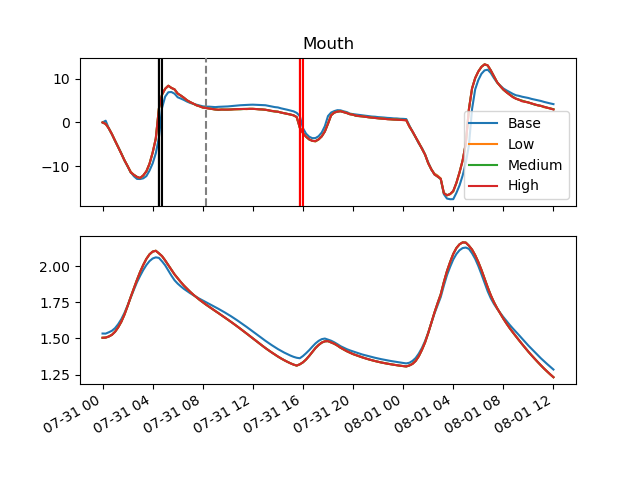

<IPython.core.display.Javascript object>


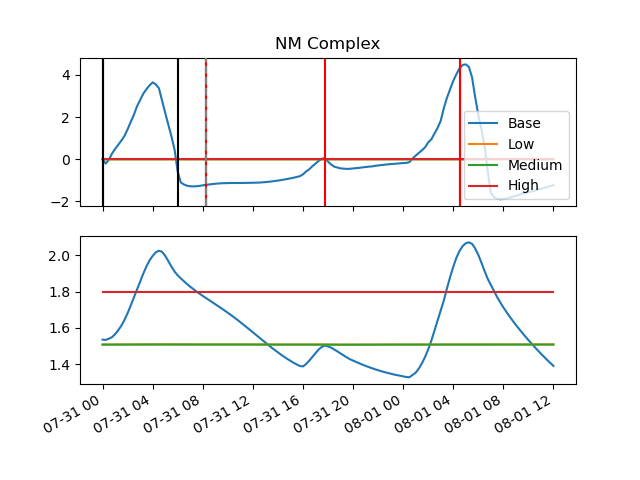

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


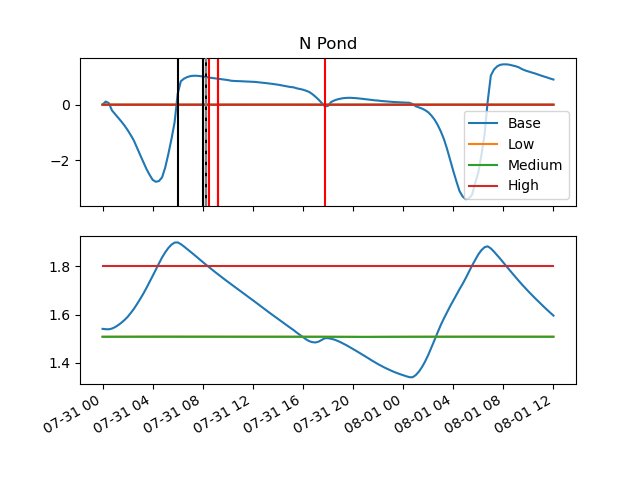

<IPython.core.display.Javascript object>


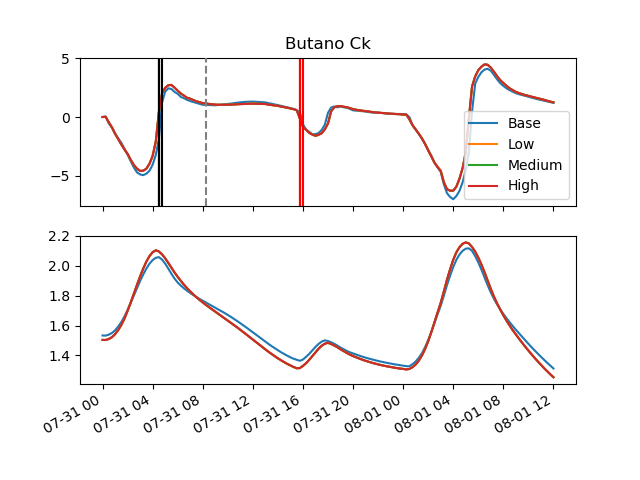

<IPython.core.display.Javascript object>


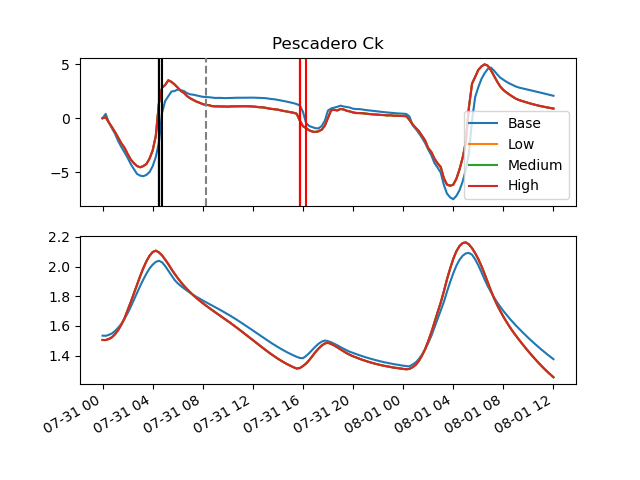

In [25]:
# Troubleshooting/visualizing the tide that went into tidal prism.
# Mouth is okay
# NM Complex is messy -- but it might be okay for Base, and just 
#  flipped. Fixed well enough.
# NM N Ditch is much better, though it still rolls over the
# actual reversal.
# N Pond okay, it's just roughly 0 for everything but base.
# Pescadero Ok.

for sec in section_sel:
    #sec='butano_lower_xs'
    stn=sec_station_sel[sec]

    fig,(ax,ax_eta)=plt.subplots(2,1,sharex=True)

    ax.axvline(ebb_time,color='0.5',ls='--',zorder=3)
    for _,row in tidal_runs.iterrows():
        his=row['model'].his_dataset()
        ax.plot(his.time, his.cross_section_discharge.sel(cross_section=sec),
                label=row['name'])
        ax_eta.plot(his.time, his.waterlevel.sel(stations=stn),
                    label=row['name'])

    secs_ds=prisms_ds.sel(cross_section=sec)
    for t_start in secs_ds.t_start.values:
        ax.axvline(t_start,color='k')
    for t_stop in secs_ds.t_stop.values:
        ax.axvline(t_stop,color='r')

    ax.legend(loc='lower right')
    ax.set_title(section_sel[sec])
    fig.autofmt_xdate()

Freshening
----

Time for depth-averaged salinity to reach 5ppt, after closure.

In [26]:
runs

run_dir  scen  layers    period  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v027     0     100  2016long   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v004     1     100  2016long   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  2016long   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v010     3     100  2016long   

    status     flows comments  slr    name  \
0  running  impaired      NaN  NaN    Base   
1  running  impaired      NaN  NaN     Low   
2  stopped  impaired      NaN  NaN  Medium   
3  running  impaired      NaN  NaN    High   

                                               model  \
0  <stompy.model.delft.dflow_model.DFlowModel obj...   
1  <stompy.model.delft.dflow_model.DFlowModel obj...   
2  <stompy.model.delft.dflow_model.DFlowModel obj...   
3  <stompy.model.delft.dflow_model.DFlowModel obj...   

                                                 his  
0  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...  
1  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...  
2  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...  
3  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...

In [27]:
fresh_runs=runs 
#fresh_runs['model']=fresh_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
#fresh_runs['his']=fresh_runs.model.apply(lambda mod: mod.his_dataset())

In [28]:
# First, just use the map output
for _,row in fresh_runs.iterrows():
    model=row['model']
    mds=model.map_dataset(chain=True)
    break    

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


In [29]:
t_close=np.datetime64("2016-08-11 00:00")

<IPython.core.display.Javascript object>


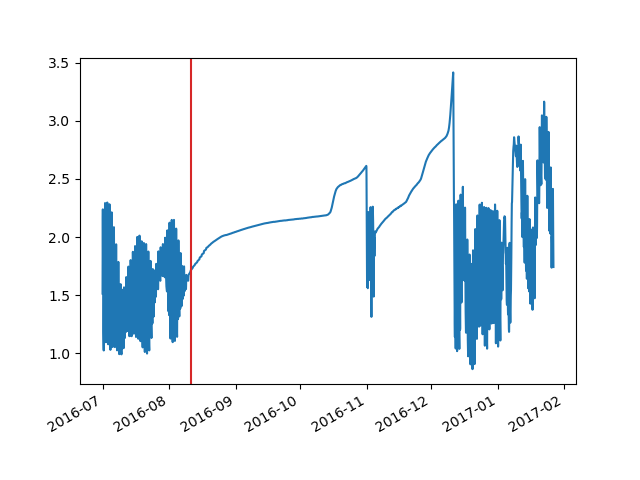

In [30]:
# When did it close?  Hopefully all of the runs will use the same starting
# time, so we can reuse the closure timing
# 8-09 might be closer?
his_ds=fresh_runs.model.values[0].his_dataset()
nck=his_ds.waterlevel.sel(stations='nck')
fig,ax=plt.subplots()
ax.plot(nck.time, nck)
ax.axvline(t_close,color='tab:red')
fig.autofmt_xdate()

In [31]:
print("Days after closure of mini-breach",(np.datetime64('2016-11-01') - t_close)/np.timedelta64(1,'D'))
print("Days after closure of large breach",(np.datetime64('2016-12-11') - t_close)/np.timedelta64(1,'D'))

Days after closure of mini-breach 82.0
Days after closure of large breach 122.0


In [32]:
from stompy.grid import ugrid
six.moves.reload_module(ugrid)

def s_davg(mds,ti):
    snap=mds.isel(time=ti)
    salt=snap['mesh2d_sa1'].values
    
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0)
    s_davg=np.nansum(weights*salt,axis=1)
    dry=np.all(np.isnan(weights),axis=1)
    s_davg[dry]=np.nan
    return s_davg

def calc_days_to_freshen(mod,t_close,s_thresh=5.0):
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t_close)
    
    t_fresh=np.nan*np.ones(mds.grid.Ncells())
    time_vals=mds.time.values
    t0=time_vals[ti_close]

    # HERE - need chaining logic.
    for ti in range(ti_close,mds.dims['time']):
        #print(f"{ti}/{mds.dims['time']}", end='  ')    
        print(".",end="")
        salt_i=s_davg(mds,ti)
        fresh=(salt_i<s_thresh) & np.isnan(t_fresh)
        t_fresh[fresh]=(time_vals[ti]-t0)/np.timedelta64(86400,'s')
    return t_fresh

In [33]:
# Survey initial, depth-averaged salinity field
def figure_salinity(mod,t=t_close,label=None):
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t)
    if t < mds.time.values[0]:
        # HERE -- add some restart chaining logic
        logging.warning("Output starts after the requested time")
    salt0=s_davg(mds,ti_close)

    fig,ax=plt.subplots(figsize=(7.2,4.75))
    ax.set_adjustable('datalim')
    ccoll=mds.grid.plot_cells(values=salt0,cmap='turbo',clim=[0,34])
    bgcoll=mds.grid.plot_cells(mask=np.isnan(salt0),color='0.85',zorder=-2,lw=0.5,edgecolor='face')

    ax.axis('off')
    #zoom=[551953., 553097.,4124145., 4125066.]
    zoom=[551951., 553291., 4124136., 4125020.]
    ax.axis(zoom)
    cax=fig.add_axes([0.55,0.9,0.40,0.03])
    cbar=plt.colorbar(ccoll,cax=cax,orientation='horizontal',label='psu')
    fig.subplots_adjust(left=0.0,right=1.0,top=1.0,bottom=0.0)
    if label:
        ax.text(0.02,0.9,label,transform=ax.transAxes)
    return fig

Base


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


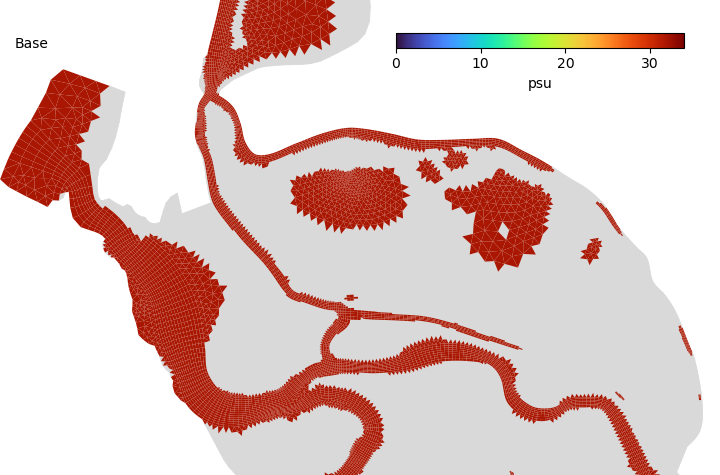

Low


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


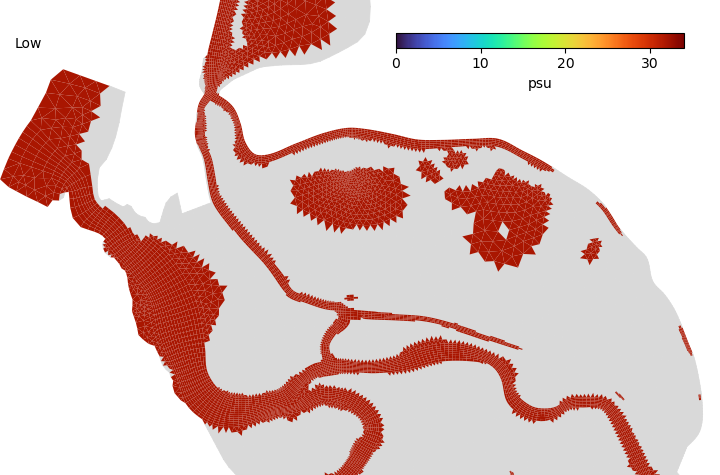

Medium


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


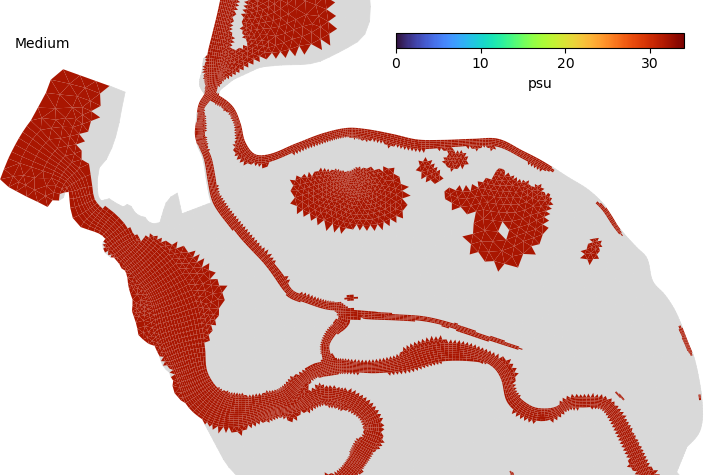

High


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


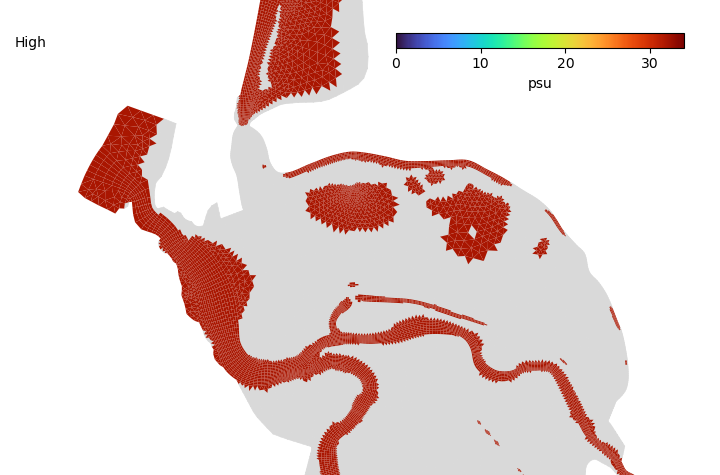

In [34]:
t_initial=np.datetime64('2016-07-01 00:00') # correct for period=2016long 

for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset(chain=True)
    # HERE: for a resumed run this will not be correct.
    fig=figure_salinity(run['model'],t=t_initial,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-initial-{run["name"]}.png'),
               dpi=200)

Base


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


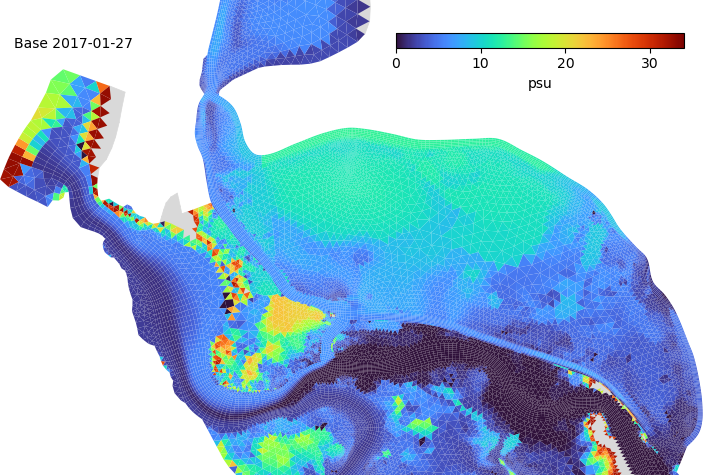

Low


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


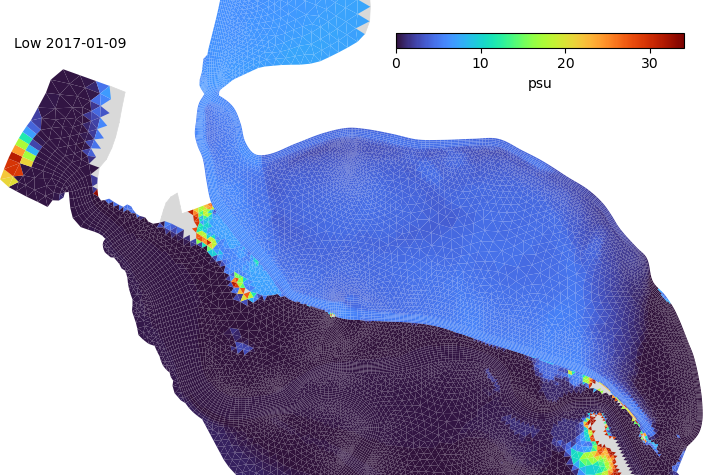

Medium


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


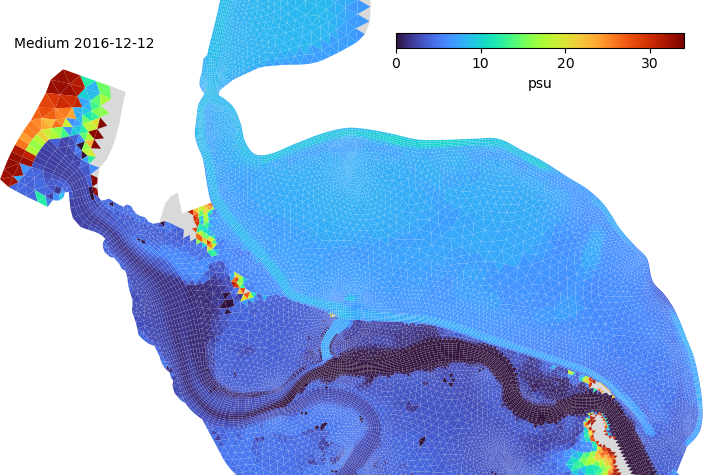

High


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>

In [35]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset()
    t_stop=mapds.time.values[-1]
    t_stop_label=utils.to_datetime(t_stop).strftime('%Y-%m-%d')
    fig=figure_salinity(run['model'],t=t_stop,label=f"{run['name']} {t_stop_label}")
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-final-{run["name"]}.png'),
               dpi=200)                

Base


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>

Low


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


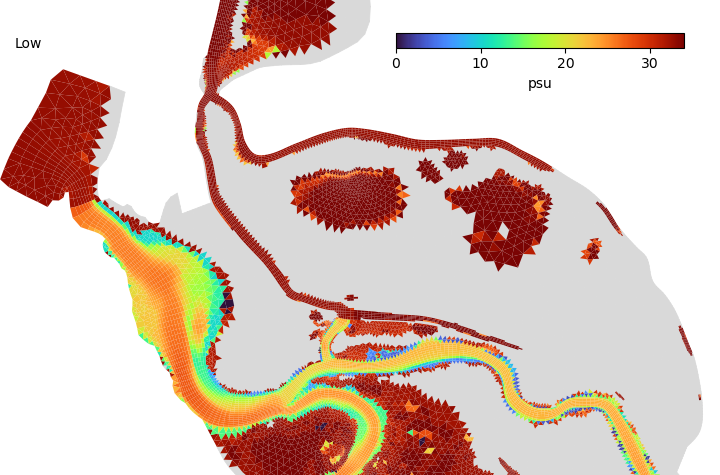

Medium


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


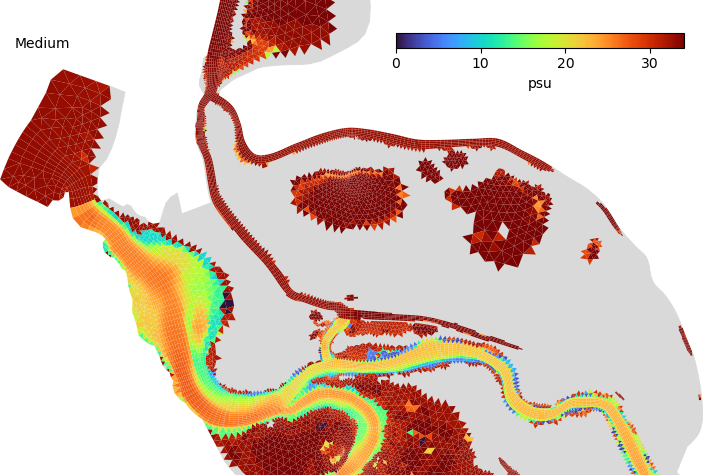

High


/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>

In [36]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    fig=figure_salinity(run['model'],t=t_close,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-at_closure-{run["name"]}.png'),
               dpi=200)
    

In [37]:
def fig_freshen(rec,t_close=t_close,max_days=160):
    mod=rec['model']
    mds=mod.map_dataset(chain=True)
    duration_days=(mds.time.values[-1]-t_close)/np.timedelta64(1,'D')
    print(f"Days to freshen from closure {t_close} to end of run {mds.time.values[-1]} ({duration_days:.1f}d)")

    t_fresh=calc_days_to_freshen(mod,t_close)
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    mds.grid.plot_cells(color='0.65',zorder=-1)
    ccoll=mds.grid.plot_cells(values=t_fresh,mask=np.isfinite(t_fresh),cmap='turbo',zorder=1)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.02)
    cax=fig.add_axes([0.05,0.08,0.03,0.45])
    plt.colorbar(ccoll,cax=cax,label="days")
    ccoll.set_clim([0,max_days])
    zoom=[551894., 553097.,4124145., 4125066.]
    ax.axis(zoom)
    return fig

In [38]:
if 0: # Close look at the odd-ball 0-day cells in all scenarios.
    p=[552982, 4124523]
    mod=fresh_runs.model.values[0]
    mapds=mod.map_dataset()
    c=mapds.grid.select_cells_nearest(p)

    ti_close = np.searchsorted(mapds.time.values, t_close)

    salt=mapds['mesh2d_sa1'].isel(mesh2d_nFaces=c,time=ti_close)
    # all nan with a single entry of 32.0, at laydim=72
    np.nonzero( np.isfinite(salt.values))

    salt_davg=s_davg(mapds,ti_close)
    salt_davg[c] # -0.0542.  WTF?

    mds=mapds
    ti=ti_close
    #def s_davg(mds,ti):
    snap=mds.isel(time=ti)
    #salt=snap['mesh2d_sa1'].values

    snap['mesh2d_waterdepth'].isel(mesh2d_nFaces=c)

    # mesh2d_layer_z gives elevation of layers, from deep to shallow 
    # positive-up. mesh2d_flowelem_bl is also elevation, positive-up.
    #mapds['mesh2d_flowelem_bl']
    layer_z=mapds['mesh2d_layer_z'].values
    (layer_z[71]+layer_z[72])/2 # => 2.02

    six.moves.reload_module(ugrid)
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    face_slice=np.array([c])
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0,face_slice=face_slice)
    # Still bad
    # k_sign: 1. 
    # h: 2.0200593  --- versus a layer interface at 2.0200
    # ii: 0 (I think that's just index into list of faces being processed)
    # ctops comes from searchsorted
    # k_sign=1
    # manually doing the searchsorted.  with surface_dzmin included, 2.0200593
    # hits ... 71, which is 2.022.  surface dzmin is 2mm.
    # ctops[ii]=71. # This is a little problematic. cell 72 has the non-nan salinity.
    # So k=72 is the true bed cell, with a finite salinity. 
    # h=2.0200593
    # z[ctop] 1.985 
    # Note that waterdepth is 0.0. 
    # What would it take for ctops[ii] to be 72?
    # cbeds is 72. kbed is, I think, redundant with cbed, and also 72.
    weights

    #return s_davg
    #s_davg[c] # -0.05421... !
    weights[c] # [71]: > 1, [72] < 0.
    weights

Base
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-01-27T00:00:00.000000000 (169.0d)
.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


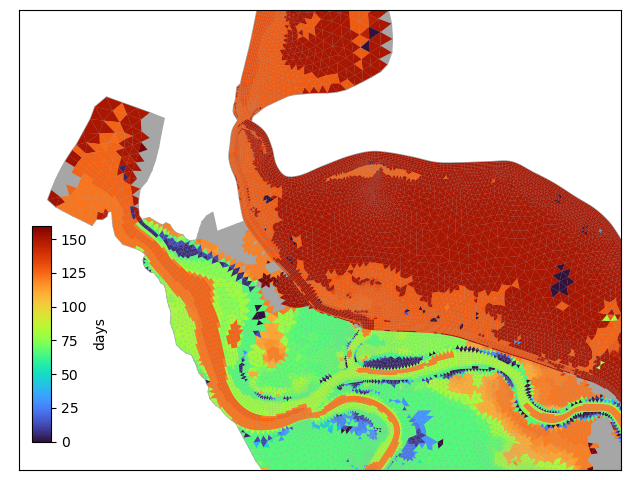

Low
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-01-09T00:00:00.000000000 (151.0d)
.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


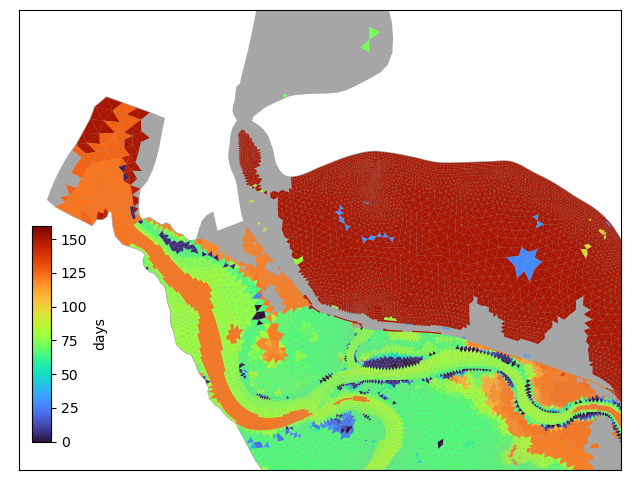

Medium
Days to freshen from closure 2016-08-11T00:00 to end of run 2016-12-12T00:00:00.000000000 (123.0d)
.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


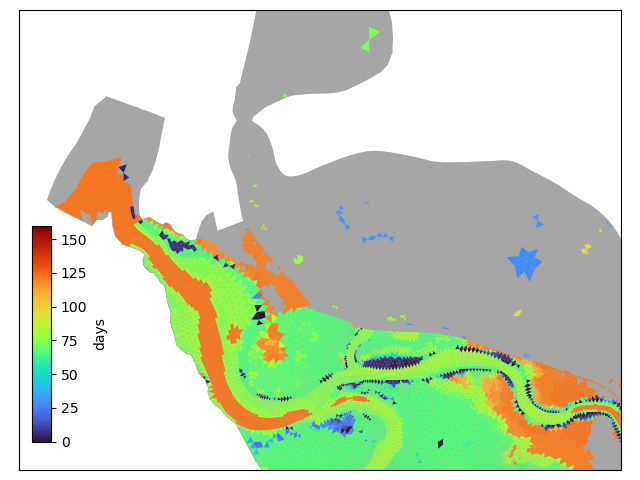

High
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-01-21T00:00:00.000000000 (163.0d)
.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


.

/home/rustyh/src/stompy/stompy/grid/ugrid.py:853: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


<IPython.core.display.Javascript object>


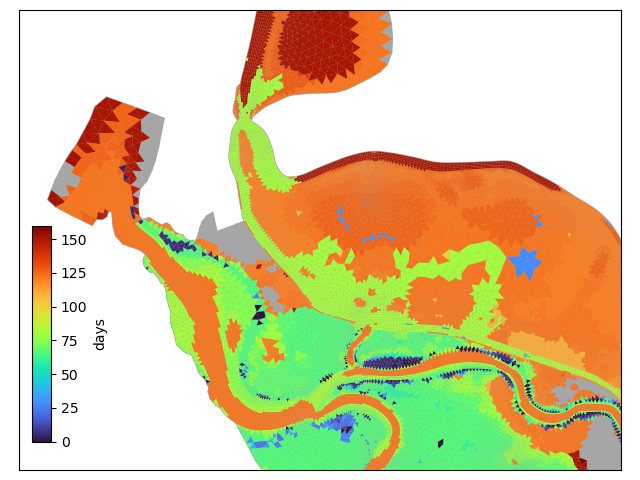

In [39]:
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    fig=fig_freshen(rec)
    fig.savefig(os.path.join(fig_dir,f"t_fresh-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)

Do the freshening figures make sense?

* note that not all runs have made it to the same time. Will now print out the period.
* what about the dark blue cells? Maybe fixed with some updates to ugrid.py.

In [ ]:
HERE 
 -- what's the next plot that makes sense with the existing runs? Maybe look at
the breach flow and where NM water goes? Check back on the scope.
 -- get restart output to work so I can switch scen2 over.

Sea Level Rise
---

Show how the inlet depth is adjusted

In [112]:
run_slr='data_2013_3d_asbuilt_impaired_slr0.61m-v002'
run_base='data_2016long_3d_asbuilt_impaired-v003'

In [113]:
model_slr=dfm.DFlowModel.load(run_slr)
model_base=dfm.DFlowModel.load(run_base)

In [114]:
mds_slr=model_slr.map_dataset()
mds_base=model_base.map_dataset(grid=mds_slr.grid)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing o

INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extra

<IPython.core.display.Javascript object>


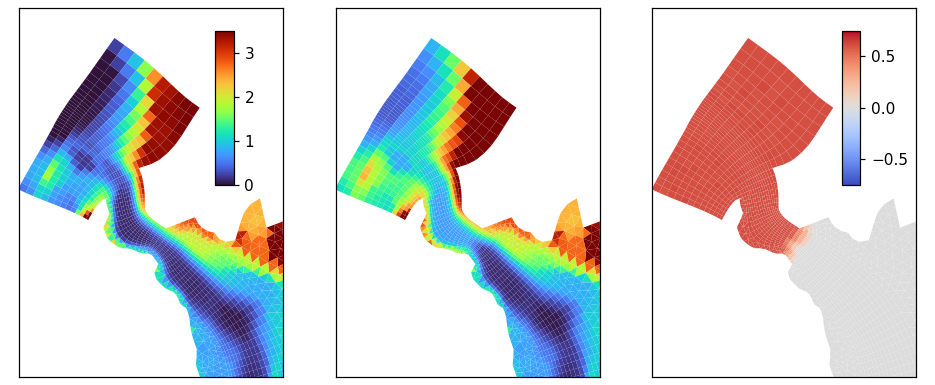

In [123]:
zoom_mouth=[551963., 552311., 4124425., 4124912.]
fig,axs=plt.subplots(1,3,figsize=[8.5,3.5])

plt.setp(axs,adjustable='datalim')

z_base=mds_base['mesh2d_flowelem_bl'].values
z_slr = mds_slr['mesh2d_flowelem_bl'].values
delta=z_slr-z_base

coll0=mds_base.grid.plot_cells(values=z_base,ax=axs[0],cmap='turbo')
coll1=mds_slr.grid.plot_cells(values=z_slr,ax=axs[1],cmap='turbo')
coll2=mds_slr.grid.plot_cells(values=delta,cmap='coolwarm',clim=[-0.75,0.75])

for coll in [coll0,coll1]:
    coll.set_clim([0,3.5])
    
for ax in axs:
    ax.axis(zoom_mouth)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02)

cax0=fig.add_axes([0.23,0.52,0.02,0.40])
cax2=fig.add_axes([0.90,0.52,0.02,0.40])
plt.colorbar(coll0,cax=cax0)
plt.colorbar(coll2,cax=cax2)
